## CS4243 Lab 4: Translation Symmetry Detection

- The functions to be implemented are given in `lab4.py`, along with the instructions for each function. You need to fill in the codes which start with `# YOUR CODE HERE` and end with `# END`
- The test images are given in folder `inputs` and sample outputs are provided in `outputs`
- You are free to use any NumPy or OpenCV functions, except the built-in functions for mean-shift such as `cv2.meanShift`. For k-means clustering, you can use `KMeans` from sklearn. Please do not import other high-level computer vision libraries.
- You can fine-tune any hyperparameter in this lab.

**Attention**:
- Most of OpenCV functions assume the input parameters of points as the order of (w, h). However, we often use the order (h, w) to denote a point. Please be very careful when you use the OpenCV functions.
- Please use python with version >= 3.5.4, and install the libs provided in requirements.txt via `pip install -r requirements.txt`.
- Please do not change the inputs arguments of the functions in `lab4.py` **except functions in Part 3**, otherwise your implementation would fail to pass the test.
- Please do not change the structure of files in the whole folder of this assignment, otherwise TA may mark your code wrongly.
- **As long as your output is close to the expected answer, you will get full credit**.

**SUBMISSION INSTRUCTIONS:**

After you finish the code and get all the results: 

   1. Zip the same folder back and name it with your student ID (e.g. A0123456H.zip or A0123456H_A2345678J.zip if you are a group of 2), and 
    
   2. Submit to the NUS Luminus system. Please be careful since any failure to follow the submission guideline will result in a grade deduction.
    
If you have any question regarding this lab, do not hesistate to ask questions under the Lab section on LumiNUS forum. You can also attend the any lab slot for FAQs.

There are **FOUR parts** for this lab.

In [100]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import importlib

import lab4

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
img_path = 'inputs/fence.jpg' # You can select a different images if you think the current image is too easy or hard.
output_dir = 'outputs'

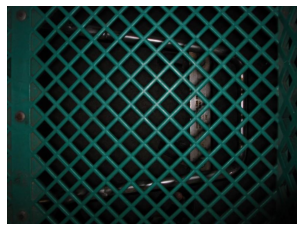

In [103]:
img_name = os.path.basename(img_path)[:-4]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h_img, w_img, c = img.shape

plt.figure()
plt.axis('off')
plt.imshow(img)

## Part 1: Shi-Tomasi Keypoint Detection and Clustering (30%)

### Part 1-1. Shi-Tomasi Keypoint Detection (10%)

**Goal**: Implement `detect_points` function and then run the code cells below.

Hint:
+ You may find the function `cv2.goodFeaturesToTrack` helpful. The initial default parameter setting is given in the notebook.

In [177]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
min_distance = 3 
rou = 0.1
# pt_num = 30
pt_num = 30
patch_size = 50
tau_rou = 0.005
gamma_rou = 0.8

pts = lab4.detect_points(img, min_distance, rou, pt_num, patch_size, tau_rou, gamma_rou)
print('Number of detected points:', pts.shape[0])
print('Type of pts:', type(pts))
print('Shape of pts:', pts.shape)
print('Element type of pts:', pts.dtype)

Number of detected points: 5160
Type of pts: <class 'numpy.ndarray'>
Shape of pts: (5160, 2)
Element type of pts: int64


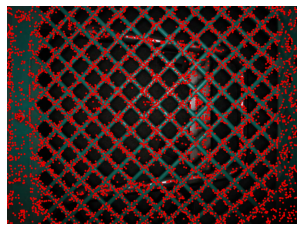

In [178]:
img_tmp = img.copy()
for p in pts:
    img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(230, 0, 0), thickness=2)
    
plt.figure()
plt.axis('off')
plt.imshow(img_tmp)

### Part 1-2. Extract point features (5%)

**Goal**: Implement `extract_point_features`.

As the point location itself cannot be used for clustering, we need to extract the features for these points. The patch feature for a point is defined as the patch extracted with this point as the center.


Note that the returned `pts` is a subset of the input `pts`. We discard some of the points as they are close to the boundary of the image and we cannot extract a full patch.


In [179]:
importlib.reload(lab4)

# Default parameter setting. Please check lab4.py for detailed information.
window_patch = 5
pts, features = lab4.extract_point_features(img, pts, window_patch)

print(features.shape)

(4969, 121)


### Part 1-3. Mean-shift clustering (10%)

**Goal**: Implement `mean_shift_clustering`

Before we group the points detected by the detector above, we can go through a simple test first to evaluate the implementation of `mean_shift_clustering`. We provide a toy example, and your objective is to implement mean-shift clustering and cluster these points. You can select the bandwidth that gives you the best result.

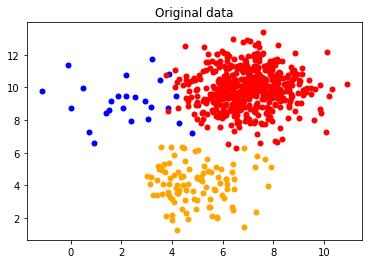

In [111]:
importlib.reload(lab4)
np.random.seed(0)

means = np.float32([[2, 9],
                    [5, 4],
                    [7, 10]])

covs = np.float32([[[1.5, 0], [0, 1.5]],
                [[1.5, 0], [0, 1.5]],
                [[1.5, 0], [0, 1.5]]])

sizes = [25, 100, 500]
xs = []

for i in range(3):
    xs.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=sizes[i]))

colors = ['blue', 'orange', 'red', 'green', 'purple', 'gray']

plt.figure()
plt.title('Original data')
for i in range(3):
    plt.scatter(xs[i][:, 0], xs[i][:, 1], color=colors[i], linewidths=0.0001)
plt.show()




Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate


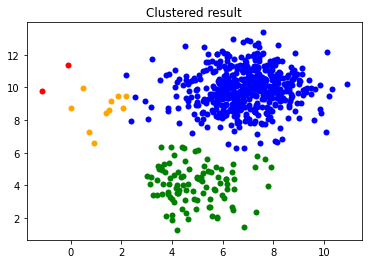

In [9]:
importlib.reload(lab4)

data = np.concatenate(xs, 0)
# Please fine-tune the bandwidth
clustering = lab4.mean_shift_clustering(data, bandwidth=1.75)

# clustering
plt.figure()
plt.title('Clustered result')
for i in range(data.shape[0]):
    plt.scatter(data[i, 0], data[i, 1], color=colors[clustering['labels_'][i]], linewidths=0.0001)
plt.show()

### Part 1-4. Clustering (5%)

**Goal**: Implement `cluster`.

Now, you need to use the mean-shift clustering to group the points with similar appearance. Then, refine the clustering results with K-means clustering.

It will take a while to run the following code. Please be patient.

In [180]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
bandwidth = 7
tau1 = 5
tau2 = 100
gamma_h = 1.1

clusters = lab4.cluster(img, pts, features, bandwidth, tau1, tau2, gamma_h)

print('Note: The following information is presented here for your debugging.')
print('You do not have to follow them strictly, and you can comment out them. It will not influence the grading.')
print('Number of clusters:', len(clusters))
print('Size of first 3 clusters:', len(clusters[0]), len(clusters[1]), len(clusters[2]))
print('Type of clusters:', type(clusters))
print('Type of element in each cluster:', type(clusters[0]))
print('Shape of element in each cluster (#points, 2):', clusters[0].shape)


Tuning bandwidth 7
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Iterate
Processing Clusters
Too big
KMeans gives 49
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Just right
Too small
Just right
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
T

The visualization of clustering is as follows. 

Each figure represents the result of one group. The red dots denote the corresponding clustered points. 

We only present 9 of them in the notebook. You should observe that the some points in the same group should fall in the same position relative to the repetitive pattern. For instance, the points are on the vertices of the fence cells.

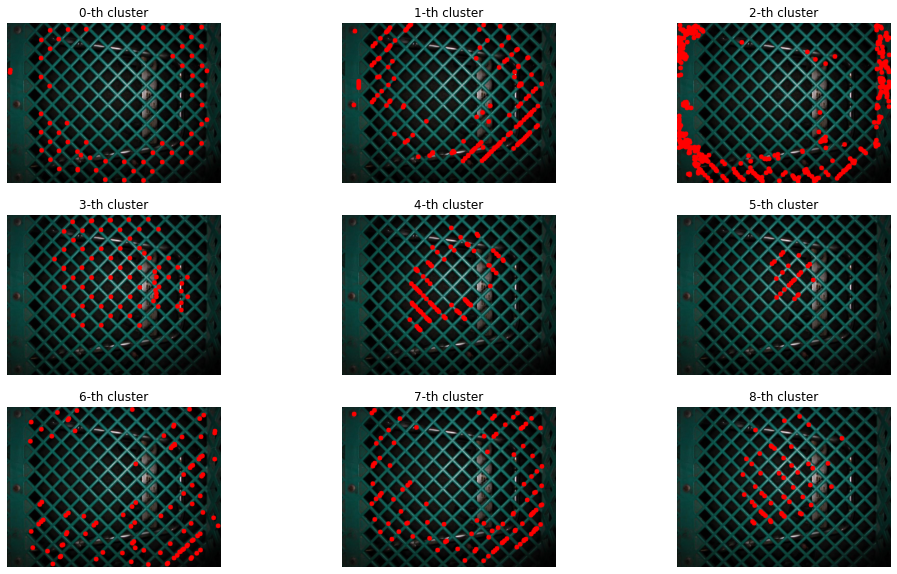

In [181]:
fig, axs = plt.subplots(3, 3, figsize=(17, 10))

for idx, c in enumerate(clusters):
    if idx > 8: # Only the first 5 clusters are presented
        break
    img_tmp = img.copy()
    for p in c:
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(255, 0, 0), thickness=15)

    ax = axs[idx // 3][idx %3]
    ax.imshow(img_tmp)
    ax.set(title='%d-th cluster'%idx)
    ax.axis('off')
plt.show()

## Part 2. Lattice Model Proposals and Evaluations (20%)

### Part 2-1. Propose Lattice Model (10%)
**Goal**: Implement `get_proposal`.

Hints:
+ As stated in the lab4.pdf, we give priority to points close to each other when we sample a triplet.
        This statement means that we can start from the three closest points and iterate N_a times.
        There is no need to go through every triplet combination.
        For instance, you can iterate over each point. For each point, you choose 2 of the 10 nearest points. The 3 points form a triplet.
        In this case N_a = num_points * 45.

+ It is recommended that you reorder the 3 points. 
    Since {a, b, c} are transformed onto {(0, 0), (1, 0), (0, 1)} respectively, the point a is expected to be the vertex opposite the longest side of the triangle formed by these three points

+ Another way of refining the choice of triplet is to keep the triplet whose angle (between the edges <a, b> and <a, c>) is within a certain range.
    The range, for instance, is between 20 degrees and 120 degrees.

+ You may find `cv2.getAffineTransform` helpful. However, be careful about the HW and WH ordering when you use this function.

+ If two triplets yield the same number of inliers, keep the one with closest 3 points.

The output of `get_proposal()` is a list of dictionary. Each dictionary element contains two keys:
+ `pt` is the image coordinate of an inlier point
+ `pt_int` is the corresponding integer position

Please follow this naming, as the visualization codes use `pt` and `pt_int`.

Furthermore, the first 3 elements in the dictionary should correspond repspectively to `{(0, 0), (1, 0), (0, 1)}`

In [182]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
tau_a = 0.2
X = 20

proposals = []
for i in range(len(clusters)):
    pts_cluster = clusters[i] # The points in i-th cluster
    proposal = lab4.get_proposal(pts_cluster, tau_a, X)
    proposals.append(proposal)
    
    if i <= 5:
        print('*'*30, '%d-th cluster'%i, '*'*30)
        for inlier in proposal:
            print(inlier)

****************************** 0-th cluster ******************************
{'pt_int': array([0, 0]), 'pt': array([521, 510])}
{'pt_int': array([1, 0]), 'pt': array([556, 543])}
{'pt_int': array([0, 1]), 'pt': array([555, 473])}
{'pt_int': array([ 0, -1]), 'pt': array([486, 545])}
{'pt_int': array([1, 1]), 'pt': array([590, 510])}
{'pt_int': array([ 1, -1]), 'pt': array([521, 580])}
{'pt_int': array([-1,  1]), 'pt': array([520, 438])}
{'pt_int': array([ 0, -2]), 'pt': array([451, 580])}
{'pt_int': array([0, 2]), 'pt': array([589, 438])}
{'pt_int': array([ 1, -2]), 'pt': array([486, 616])}
{'pt_int': array([-2,  2]), 'pt': array([518, 368])}
{'pt_int': array([ 2, -2]), 'pt': array([521, 654])}
{'pt_int': array([-1,  3]), 'pt': array([587, 367])}
{'pt_int': array([ 1, -3]), 'pt': array([452, 654])}
{'pt_int': array([-2,  3]), 'pt': array([552, 333])}
{'pt_int': array([ 2, -3]), 'pt': array([486, 688])}
{'pt_int': array([ 1, -4]), 'pt': array([415, 689])}
{'pt_int': array([-4,  2]), 'pt': 

The visualization of proposals is given as follows. The red and blue dots represent the inlier and outlier points, respectively. The basis vectors are denoted as green arrows.

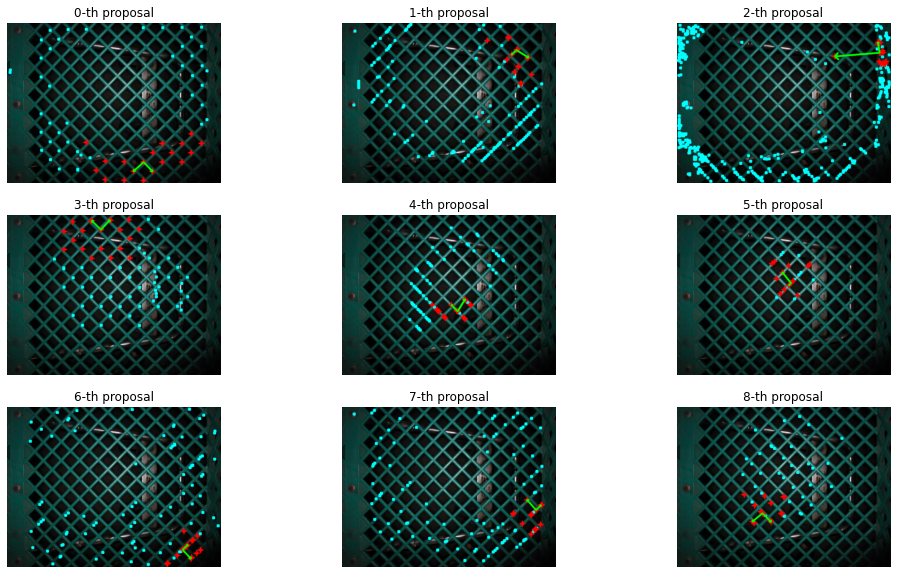

In [183]:
fig, axs = plt.subplots(3, 3, figsize=(17, 10))

for idx_p, proposal in enumerate(proposals):
    if idx_p > 8: break
    
    img_tmp = img.copy()
    for p in clusters[idx_p]:
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(0, 255, 255), thickness=10)
        
    for idx, inlier in enumerate(proposal):
        p = inlier['pt']
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(255, 0, 0), thickness=10)
        img_tmp = cv2.drawMarker(img_tmp, (int(p[1]), int(p[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=3)
        
    # Draw (t1, t2) vector
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[1]['pt'][1]), int(proposal[1]['pt'][0])), (0, 255, 0), thickness=5) # t1
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[2]['pt'][1]), int(proposal[2]['pt'][0])), (0, 255, 0), thickness=5) # t2

    ax = axs[idx_p // 3][idx_p %3]
    ax.imshow(img_tmp)
    ax.set(title='%d-th proposal'%idx_p)
    ax.axis('off')
plt.show()

Before we start to perform perspective transformation, we provide a simple demo here to help you familiarize yourself with OpenCV perspective function.

In this demo, we only have 3 keypoints for a unit pattern, but we predict the 4-th point from these 3 keypoints. If the unit pattern already has 4 points, then no need to predict the other one.

The predicted 4th point: [297. 446.]


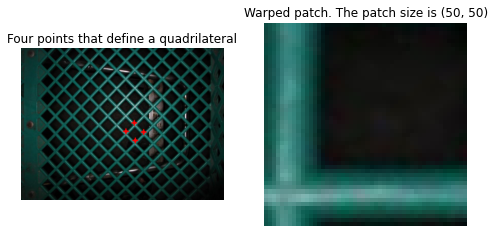

In [184]:
img_demo = cv2.imread('inputs/fence.jpg')
img_demo = cv2.cvtColor(img_demo, cv2.COLOR_BGR2RGB)
window = 50
corners_src = [np.float32([333, 483]),
               np.float32([366, 450]),
               np.float32([330, 413])] # (h, w) ordering
point_fourth = corners_src[1] + (corners_src[0] - corners_src[1]) + (corners_src[2] - corners_src[1])
print('The predicted 4th point:', point_fourth)
corners_src.append(point_fourth)
corners_src = np.float32(corners_src)
corners_dst = np.float32([[ 0,  0],
                          [window,  0],
                          [window, window],
                          [0, window]])
matrix_projective = cv2.getPerspectiveTransform(corners_src[:, [1, 0]], corners_dst) # transpose (h, w), as the input argument of cv2.getPerspectiveTransform is (w, h) ordering
img_demo_warped = cv2.warpPerspective(img_demo, matrix_projective, (window, window))
img_demo_tmp = img_demo.copy()
for p in corners_src:
    img_demo_tmp = cv2.circle(img_demo_tmp, (int(p[1]), int(p[0])), radius=1, color=(255, 0, 0), thickness=10)
    img_demo_tmp = cv2.drawMarker(img_demo_tmp, (int(p[1]), int(p[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=3)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].imshow(img_demo_tmp)
axs[0].axis('off')
axs[0].set(title='Four points that define a quadrilateral')

axs[1].imshow(img_demo_warped)
axs[1].axis('off')
axs[1].set(title='Warped patch. The patch size is %s'%(str(img_demo_warped.shape[:2])))

plt.show()

### Part 2-2. Find Texels (5%)

**Goal**: Implement `find_texels`.

Hints:
+ This function works on RGB image, unlike previous functions such as point detection and clustering that operate on grayscale image.
+ You may find `cv2.getPerspectiveTransform` and `cv2.warpPerspective` helpful.
    Please refer to the demo above for the usage of the 2 functions.
    Be careful about the HW and WH ordering when you use these function.

+ As stated in the pdf, each texel is defined by 3 or 4 inlier keypoints on the corners.
    If you find this sentence difficult to understand, you can go to check the demo.
    In the demo, a corresponding texel is obtained from 3 points. The 4th point is predicted from the 3 points.

In [185]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
texel_size = 50

a_scores = []
texels_list = []
for i in range(len(proposals)):
    texels = lab4.find_texels(img, proposals[i], texel_size=texel_size)
    texels_list.append(texels)

print('Shape of texels (#texels, H, W, #channels):', texels_list[0].shape)

Shape of texels (#texels, H, W, #channels): (969, 50, 50, 3)


The visualization of found texels is as follows. 

We present the results of the first 6 clusters and their correponding 4 texels given by the inlier points. In the example below, the first cluster only gives 2 texels, so the two figures on the right hand side are left as empty. 

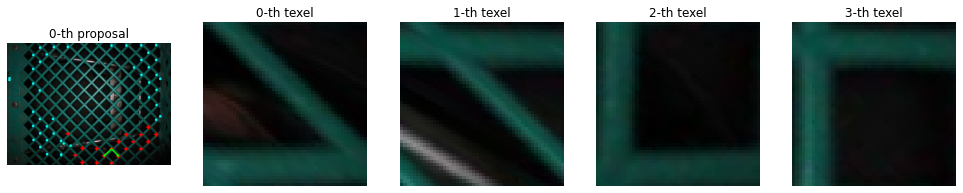

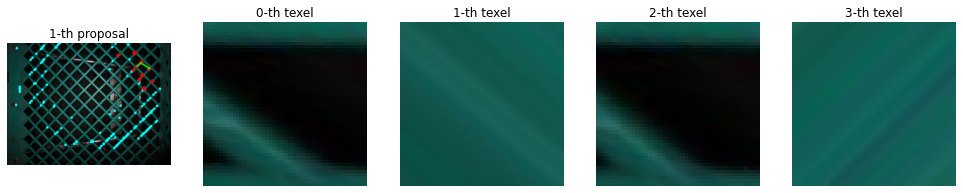

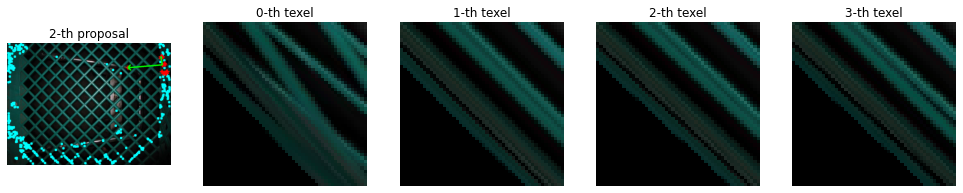

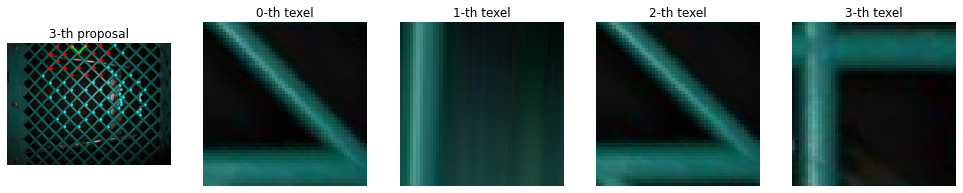

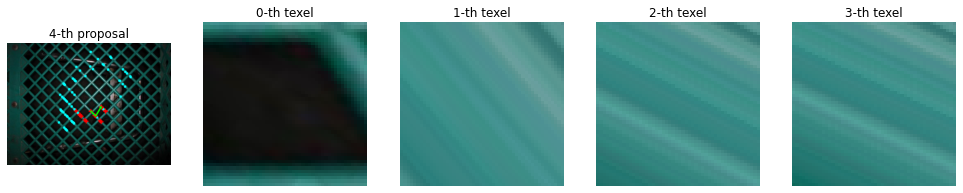

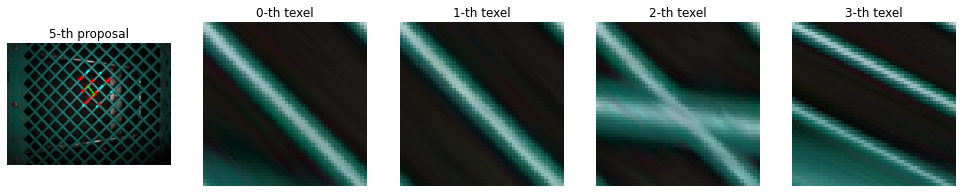

In [186]:
for idx_p, proposal in enumerate(proposals):
    if idx_p > 5: break
    
    img_tmp = img.copy()
    for p in clusters[idx_p]:
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(0, 255, 255), thickness=10)
        
    for idx, inlier in enumerate(proposal):
        p = inlier['pt']
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(255, 0, 0), thickness=10)
        img_tmp = cv2.drawMarker(img_tmp, (int(p[1]), int(p[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=3)
        
    # Draw (t1, t2) vector
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[1]['pt'][1]), int(proposal[1]['pt'][0])), (0, 255, 0), thickness=5) # t1
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[2]['pt'][1]), int(proposal[2]['pt'][0])), (0, 255, 0), thickness=5) # t2

    fig, axs = plt.subplots(1, 5, figsize=(17, 5))
    axs[0].imshow(img_tmp)
    axs[0].set(title='%d-th proposal'%idx_p)
    axs[0].axis('off')
    
    for idx_texel in range(4):
        if idx_texel >= texels_list[idx_p].shape[0]: break
        axs[idx_texel + 1].imshow(texels_list[idx_p][idx_texel])
        axs[idx_texel + 1].set(title='%d-th texel'%idx_texel)
        axs[idx_texel + 1].axis('off')
plt.show()

### Part 2-3. Score Proposal (5%)

**Goal**: Implement `score_proposal`.

After finding the repetitive texels from the previous step, we need to score each proposal to filter out bad proposals.

Hints:
1. Each channel is normalized separately.
    The A-score for a RGB texel is the average of 3 A-scores of each channel.

2. You can return 1000 (in our example) to denote a invalid A-score.
    An invalid A-score is usually results from clusters with less than "a_score_count_min" texels.


In [187]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
a_score_count_min = 3

a_scores = []
for i in range(len(proposals)):
    a_score = lab4.score_proposal(texels_list[i], a_score_count_min=a_score_count_min)
    a_scores.append(a_score)
    print('A score of %d-th cluster: %f'%(i, a_score))

A score of 0-th cluster: 0.027700
A score of 1-th cluster: 0.039103
A score of 2-th cluster: 0.022997
A score of 3-th cluster: 0.026566
A score of 4-th cluster: 0.038644
A score of 5-th cluster: 0.053811
A score of 6-th cluster: 0.038996
A score of 7-th cluster: 0.042873
A score of 8-th cluster: 0.038494
A score of 9-th cluster: 0.041965
A score of 10-th cluster: 0.047177
A score of 11-th cluster: 0.061622
A score of 12-th cluster: 0.026333
A score of 13-th cluster: 0.033902
A score of 14-th cluster: 0.025070
A score of 15-th cluster: 0.035275
A score of 16-th cluster: 0.034641
A score of 17-th cluster: 0.037766
A score of 18-th cluster: 0.035818
A score of 19-th cluster: 0.033485
A score of 20-th cluster: 0.024383
A score of 21-th cluster: 0.036957
A score of 22-th cluster: 0.054246
A score of 23-th cluster: 0.031531
A score of 24-th cluster: 0.024110
A score of 25-th cluster: 0.032192
A score of 26-th cluster: 0.025345
A score of 27-th cluster: 0.034321
A score of 28-th cluster: 0.03

We select the 3 proposals with the lowest A-scores for further processing...

In [188]:
top_n = 3 # the top "top_n" proposed lattices will be presented 
ranking = sorted(map(lambda x:(x[1], x[0]), enumerate(a_scores)))
print('%d proposals with the lowest A-scores:'%top_n)
for i in range(top_n):
    print('Cluster %d: %f'%(ranking[i][1], ranking[i][0]))

3 proposals with the lowest A-scores:
Cluster 2: 0.022997
Cluster 48: 0.023850
Cluster 31: 0.023981


The visualization of the 3 proposals is as follows.

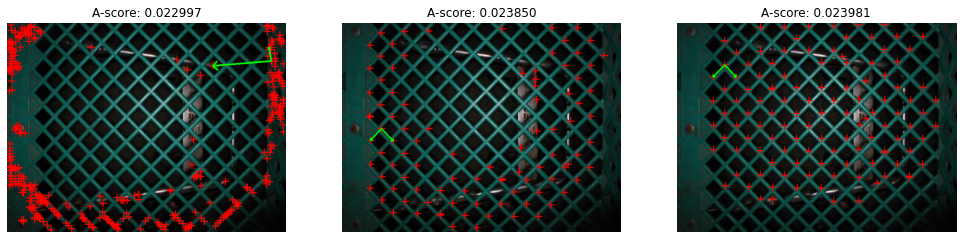

In [189]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    
for i in range(top_n): # Display the first top_n proposal
    img_tmp = img.copy()
    idx = ranking[i][1]
    proposal = proposals[idx]
    
    for p in clusters[idx]:
        img_tmp = cv2.circle(img_tmp, (int(p[1]), int(p[0])), radius=1, color=(255, 0, 0), thickness=3)
        img_tmp = cv2.drawMarker(img_tmp, (int(p[1]), int(p[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, thickness=2)

    
    # Draw (t1, t2) vector
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[1]['pt'][1]), int(proposal[1]['pt'][0])), (0, 255, 0), thickness=3) # t1
    img_tmp = cv2.arrowedLine(img_tmp, (int(proposal[0]['pt'][1]), int(proposal[0]['pt'][0])), (int(proposal[2]['pt'][1]), int(proposal[2]['pt'][0])), (0, 255, 0), thickness=3) # t2

    axs[i].imshow(img_tmp)
    axs[i].set(title='A-score: %f'%ranking[i][0])
    axs[i].axis('off')
    
plt.show()

## Part 3. Generate Lattice (20%)


In this part, you don't need to follow the input or output data type shown below strictly in this part. We present the example output just for your reference. We grade your implementation only on the visualization results.

### Part 3-1. Template Matching (5%)

**Goal**: Implement `template_match`.


Hints:
+ You may find cv2.copyMakeBorder and cv2.matchTemplate helpful. The cv2.copyMakeBorder is used for padding.
    Alternatively, you can use your implementation in Lab 1 for template matching.

+ For non-maximum suppression, you can either use the one you implemented for lab 1 or the code given in `lab4.py`.

You need to perform template matching and non-maximum suppression in this step.

In [198]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
threshold = 0.8

responses = []
for i in range(top_n):
    cluster_id = ranking[i][1]
    # You can change your input arguments for this function
    response = lab4.template_match(img, proposals[cluster_id], threshold=threshold)
    responses.append(response)


The visualization of 3 response maps is as follows. Each green dot represents a local maxima detected by non-maximum suppression.

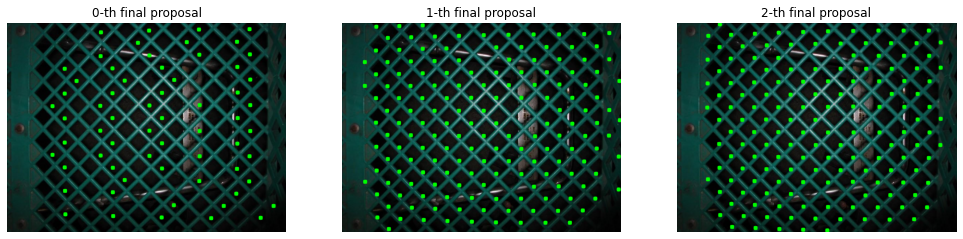

In [199]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i in range(top_n): # Display the first top_n proposal
    img_tmp = img.copy()
    idx = ranking[i][1]
    proposal = proposals[idx]
    
    nonzero_tmp = responses[i].nonzero()
    for (x, y) in list(zip(nonzero_tmp[0], nonzero_tmp[1])):
        img_tmp = cv2.circle(img_tmp, (int(y), int(x)), radius=1, color=(0, 255, 0), thickness=10)
        
    axs[i].imshow(img_tmp)
    axs[i].set(title='%d-th final proposal'%i)
    axs[i].axis('off')
    
plt.show()

### Part 3-2. Local Maxima to Grid Points (5%)
**Goal**: Implement `maxima2grid`.

Hints:
+ We can transfer the 4 offsets between the center of the original template and 4 lattice unit points to new detected centers.

In [192]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

# Default parameter setting. Please check lab4.py for detailed information.
threshold = 0.4

points_grid_list = []
for i in range(top_n):
    cluster_id = ranking[i][1]
    # You can change the input arguments of generate_lattice if you want to implement it in your own way
    points_grid = lab4.maxima2grid(img, proposals[cluster_id], responses[i])
    points_grid_list.append(points_grid)
    
print('Shape of example points_grid (#grid points, 2):', points_grid_list[0].shape)

Shape of example points_grid (#grid points, 2): (408, 2)


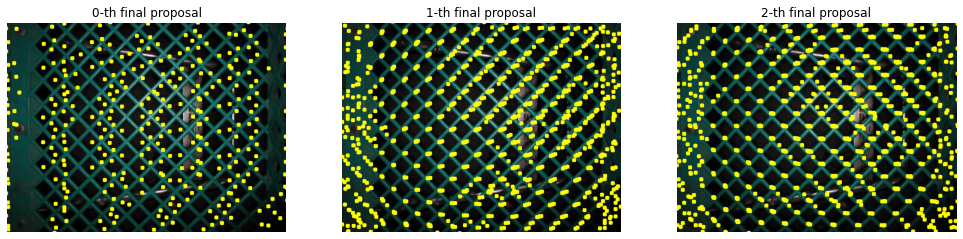

In [193]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i in range(top_n): # Display the first top_n proposal
    img_tmp = img.copy()
    idx = ranking[i][1]
    proposal = proposals[idx]
    
    for (x, y) in points_grid_list[i]:
        img_tmp = cv2.circle(img_tmp, (int(y), int(x)), radius=1, color=(255, 255, 0), thickness=10)
        
    axs[i].imshow(img_tmp)
    axs[i].set(title='%d-th final proposal'%i)
    axs[i].axis('off')
    
plt.show()

### Part 3-3. Refine Grid Points (5%)

**Goal**. Implement `refine_grid`.

Merge overlapping points and interpolate missing grid points.

In [128]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result

points_list = []
for i in range(top_n):
    cluster_id = ranking[i][1]
    # You can change the input arguments of generate_lattice if you want to implement it in your own way
    points = lab4.refine_grid(img, proposals[cluster_id], points_grid_list[i])
    points_list.append(points)
    
print('Shape of example refined points (#grid points, 2):', points_list[0].shape)

NameError: name 'points' is not defined

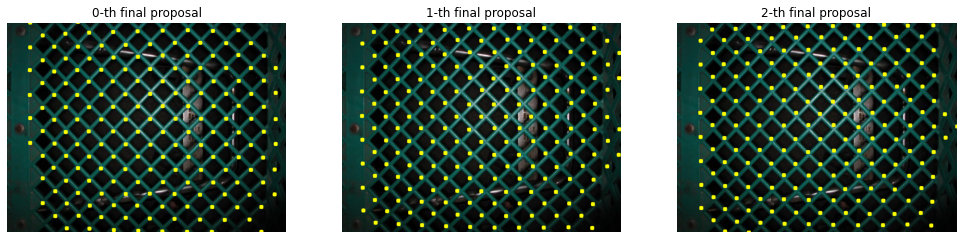

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i in range(top_n): # Display the first top_n proposal
    img_tmp = img.copy()
    idx = ranking[i][1]
    proposal = proposals[idx]
    
    for (x, y) in points_list[i]:
        img_tmp = cv2.circle(img_tmp, (int(y), int(x)), radius=1, color=(255, 255, 0), thickness=10)
        
    axs[i].imshow(img_tmp)
    axs[i].set(title='%d-th final proposal'%i)
    axs[i].axis('off')
    
plt.show()

### Part 3-4. Map grid points to lattice unit and Draw the lattice (5%)
**Goal**: Implement `grid2latticeunit`.

Hints:

+ Since it is difficult to know whether two points should be connected, one way is to map each point into an integer position.
    The integer position should maintain the spatial relationship of these points.
    For instance, if we have three points x1=(50, 50), x2=(70, 50) and x3=(70, 70), we can map them (4, 5), (5, 5) and (5, 6).
    As the distances between (4, 5) and (5, 5), (5, 5) and (5, 6) are both 1, we know that (x1, x2) and (x2, x3) form two edges.

+ You can use affine transformation to build the mapping above, but do not perform global affine transformation.

+ The mapping in the hints above are merely to know whether two points should be connected. 
    If you have your own method for finding the relationship, feel free to implement your owns and ignore the hints above.


**Of the three results obtained, we will give full marks as long as one of them is similar to the example outputs in the notebook.**

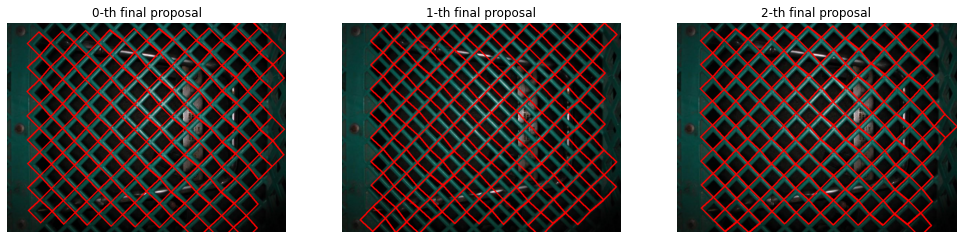

In [104]:
importlib.reload(lab4)

np.random.seed(0) # you can adjust the random seed to get a better result
edges_list = []

for i in range(top_n):
    cluster_id = ranking[i][1]
    # You can change the input arguments of this function
    edges = lab4.grid2latticeunit(img, proposals[cluster_id], points_list[i])
    edges_list.append(edges)
    

# ---------- Draw  Lattice ---------- 
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for idx, edges in enumerate(edges_list):
    img_tmp = img.copy()
    for e in edges:
        img_tmp = cv2.line(img_tmp, (e[0][1], e[0][0]), (e[1][1], e[1][0]), (255, 0, 0), thickness=3)
    axs[idx].set(title='%d-th final proposal'%idx)
    axs[idx].imshow(img_tmp)
    axs[idx].axis('off')
    
plt.show()

## Part 4. Exploratory Question (30%)

### Part 4-1. Patch-wise keypoint detection (6%)

Q1: Instead of detecting keypoints in a patch-wise manner, apply `cv2.goodFeaturesToTrack` to the entire image `fence.jpg` directly. Please append the result to this cell. (**Note that you need to use relative path and save your images in the submitted zip file, otherwise we cannot see your images.**)

*Answer:* <img src='path_to_your_img.jpg'/>

Q2: Compare the difference when you take $N=(P\cdot Q)\cdot N_p$ points for the entire image vs. considering $N_p$ points for each $(P\cdot Q)$ patch. Briefly describe the difference in outcome and explain why differences arise.  

*Answer: \<your answer here\>*

Q3: What are the benefits of patch-wise keypoint detection for translation symmetry detection?

*Answer: \<your answer here\>*

### Part 4-2. Clustering (6%)
Part 1 groups the points first with mean-shift clustering and then refines with a K-means clustering.  

Q1: For the first stage, explain the benefits of applying mean-shift instead of K-means. 

*Answer: \<your answer here\>*

Q2: For the refinement stage, why do we discard the small clusters? 

*Answer: \<your answer here\>*

Q3: Please briefly describe the relationship between the radius c and running time in the efficient implementation of mean-shift clustering. 

*Answer: \<your answer here\>*

### Part 4-3. Affine transformation (3%)

In Part 2, affine transformation and RANSAC are used to find proposals. In the function of `get_proposal()`, only the points closest to a are transformed. 

Q1: Why don’t we transform all points in the cluster to count the number of inliers? 

*Answer: \<your answer here\>*


### Part 4-4. Different samples (9%)

Please apply your algorithm to at least 3 other images in the inputs folder. For each image, select two results you think are the best and append them to the notebook. In this question, you do not need to select the two results with the lowest A-score. Instead, you should notice that the A-score does not really give us the best results. Please briefly explain the disadvantages of A-score. 

*For the first image:* 

<img src='path_to_your_img.jpg'>

<img src='path_to_your_img.jpg'>


*For the second image:* 

<img src='path_to_your_img.jpg'>

<img src='path_to_your_img.jpg'>

*For the third image:* 

<img src='path_to_your_img.jpg'>

<img src='path_to_your_img.jpg'>


### Part 4-5. Hard samples (6%)


Q1: Generate lattices for `wallpaper.jpg` and `house.jpg` and append your results to the notebook. 


*Answer:*

<img src='path_to_your_img.jpg'>

<img src='path_to_your_img.jpg'>


Q2: Explain your outcome based on your method for generating the lattices. For those methods which succeed, explain which aspect of the lattice generating algorithm allows it to work on these samples. For those methods which fail, explain why your algorithm fails and possibilities for improvement. Possibilities for failure include not detecting the full lattice structure (some repetitive patterns are not detected), or a distorted structure mis-aligned to the underlying image. 


*Answer: \<your answer here\>*


This is the end. Please check the notebook. If the content is all right to you, make sure to follow the submission instructions correctly.

Good work :)
